실습때 활용했던 ResNet-50과 DenseNet과 가장 비교를 많이하기에 이 두가지를 선택했고 리소스를 덜 먹는 작은 모델 DeseNet 121을 선택해서 진행했습니다.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import cv2
from PIL import Image


In [ ]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
train_dir = os.path.join(path, 'chest_xray', 'train')
val_dir = os.path.join(path, 'chest_xray', 'val')
test_dir = os.path.join(path, 'chest_xray', 'test')

In [ ]:
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
print(f"Train: Normal {train_normal}, Pneumonia {train_pneumonia}")

Train: Normal 1341, Pneumonia 3875


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
classes = train_dataset.classes
print(f"Classes: {classes}")
print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Classes: ['NORMAL', 'PNEUMONIA']
Batches - Train: 163, Val: 1, Test: 20


In [ ]:
sample_batch = next(iter(train_loader))
inputs, labels = sample_batch
print(f"Batch shape: {inputs.shape}, Labels: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


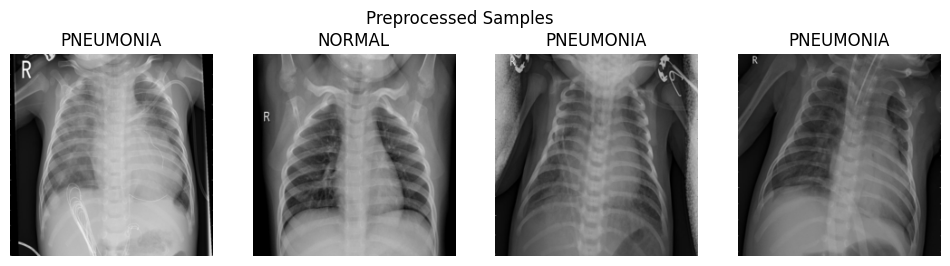

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = inputs[i].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f'{classes[labels[i]]}')
    axes[i].axis('off')
plt.suptitle('Preprocessed Samples')
plt.show()

ResNet-50 훈련

In [ ]:
resnet_model = torchvision.models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5
best_resnet_acc = 0.0

for epoch in range(num_epochs):
    # Train
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100. * correct / total

    # Validation
    resnet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = resnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100. * correct / total

    if val_acc > best_resnet_acc:
        best_resnet_acc = val_acc

    print(f'Epoch {epoch+1}: Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')

print(f"ResNet-50 Best Val Acc: {best_resnet_acc:.2f}%")

Epoch 1: 100%|██████████| 163/163 [08:59<00:00,  3.31s/it]


Epoch 1: Train Acc 97.83%, Val Acc 68.75%


Epoch 2: 100%|██████████| 163/163 [09:38<00:00,  3.55s/it]


Epoch 2: Train Acc 97.91%, Val Acc 68.75%


Epoch 3: 100%|██████████| 163/163 [09:34<00:00,  3.52s/it]


Epoch 3: Train Acc 97.99%, Val Acc 68.75%


Epoch 4: 100%|██████████| 163/163 [09:39<00:00,  3.55s/it]


Epoch 4: Train Acc 97.95%, Val Acc 68.75%


Epoch 5: 100%|██████████| 163/163 [09:38<00:00,  3.55s/it]


Epoch 5: Train Acc 97.76%, Val Acc 68.75%
ResNet-50 Best Val Acc: 68.75%


ResNet-50 테스트


In [ ]:
resnet_predictions = []
resnet_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing ResNet'):
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        resnet_predictions.extend(predicted.cpu().numpy())
        resnet_labels.extend(labels.cpu().numpy())

resnet_accuracy = accuracy_score(resnet_labels, resnet_predictions)
resnet_precision = precision_score(resnet_labels, resnet_predictions, average='weighted')
resnet_recall = recall_score(resnet_labels, resnet_predictions, average='weighted')
resnet_f1 = f1_score(resnet_labels, resnet_predictions, average='weighted')

print(f"ResNet-50 Results:")
print(f"Accuracy: {resnet_accuracy:.4f}")
print(f"Precision: {resnet_precision:.4f}")
print(f"Recall: {resnet_recall:.4f}")
print(f"F1-Score: {resnet_f1:.4f}")

Testing ResNet: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

ResNet-50 Results:
Accuracy: 0.7276
Precision: 0.8050
Recall: 0.7276
F1-Score: 0.6754


DenseNet-121 훈련


In [ ]:
densenet_model = torchvision.models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.001)

best_densenet_acc = 0.0

for epoch in range(num_epochs):
    densenet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        outputs = densenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100. * correct / total

    densenet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = densenet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100. * correct / total

    if val_acc > best_densenet_acc:
        best_densenet_acc = val_acc

    print(f'Epoch {epoch+1}: Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')

print(f"DenseNet-121 Best Val Acc: {best_densenet_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 163/163 [09:17<00:00,  3.42s/it]


Epoch 1: Train Acc 95.76%, Val Acc 93.75%


Epoch 2: 100%|██████████| 163/163 [09:26<00:00,  3.48s/it]


Epoch 2: Train Acc 97.62%, Val Acc 68.75%


Epoch 3: 100%|██████████| 163/163 [09:28<00:00,  3.49s/it]


Epoch 3: Train Acc 97.97%, Val Acc 81.25%


Epoch 4: 100%|██████████| 163/163 [09:27<00:00,  3.48s/it]


Epoch 4: Train Acc 98.33%, Val Acc 81.25%


Epoch 5: 100%|██████████| 163/163 [09:27<00:00,  3.48s/it]


Epoch 5: Train Acc 98.27%, Val Acc 100.00%
DenseNet-121 Best Val Acc: 100.00%


In [ ]:
densenet_predictions = []
densenet_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing DenseNet'):
        outputs = densenet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        densenet_predictions.extend(predicted.cpu().numpy())
        densenet_labels.extend(labels.cpu().numpy())

densenet_accuracy = accuracy_score(densenet_labels, densenet_predictions)
densenet_precision = precision_score(densenet_labels, densenet_predictions, average='weighted')
densenet_recall = recall_score(densenet_labels, densenet_predictions, average='weighted')
densenet_f1 = f1_score(densenet_labels, densenet_predictions, average='weighted')

print(f"DenseNet-121 Results:")
print(f"Accuracy: {densenet_accuracy:.4f}")
print(f"Precision: {densenet_precision:.4f}")
print(f"Recall: {densenet_recall:.4f}")
print(f"F1-Score: {densenet_f1:.4f}")


Testing DenseNet: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

DenseNet-121 Results:
Accuracy: 0.8125
Precision: 0.8533
Recall: 0.8125
F1-Score: 0.7940


In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['ResNet-50', 'DenseNet-121'],
    'Accuracy': [resnet_accuracy, densenet_accuracy],
    'Precision': [resnet_precision, densenet_precision],
    'Recall': [resnet_recall, densenet_recall],
    'F1-Score': [resnet_f1, densenet_f1]
})

print("Model Comparison:")
print(comparison_df.round(4))

Model Comparison:
          Model  Accuracy  Precision  Recall  F1-Score
0     ResNet-50    0.8462     0.8586  0.8462    0.8387
1  DenseNet-121    0.8125     0.8533  0.8125    0.7940


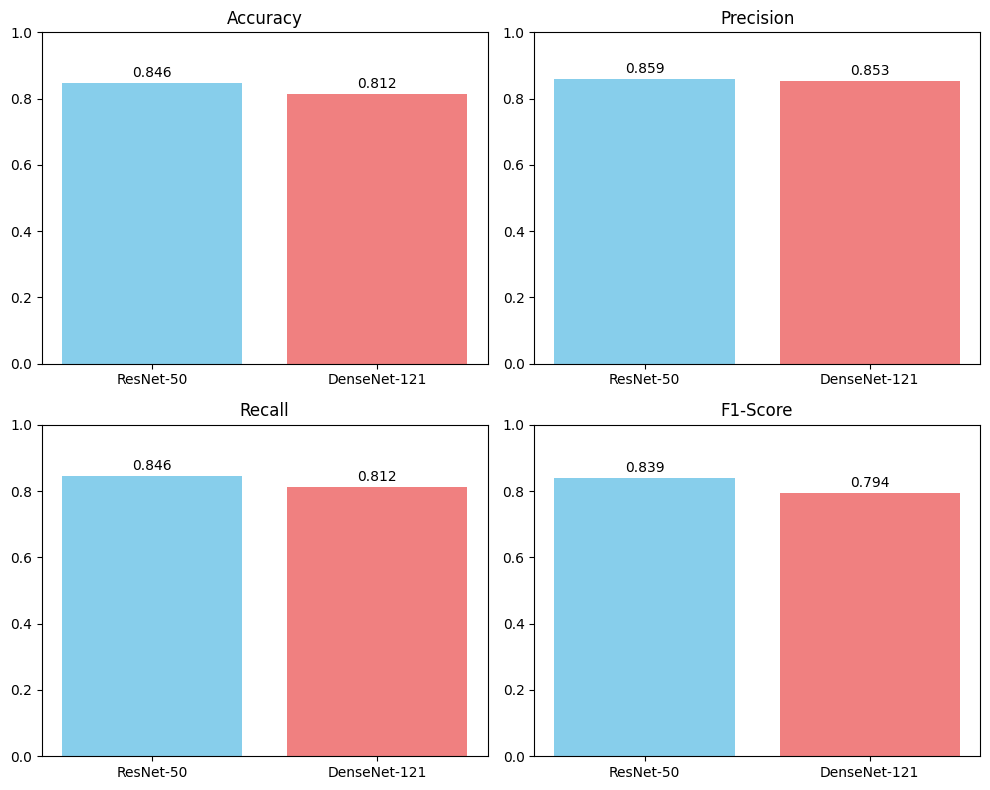

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
resnet_scores = [resnet_accuracy, resnet_precision, resnet_recall, resnet_f1]
densenet_scores = [densenet_accuracy, densenet_precision, densenet_recall, densenet_f1]

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(['ResNet-50', 'DenseNet-121'],
                  [resnet_scores[i], densenet_scores[i]],
                  color=['skyblue', 'lightcoral'])
    ax.set_title(metric)
    ax.set_ylim([0, 1])

    # 값 표시
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{[resnet_scores[i], densenet_scores[i]][j]:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

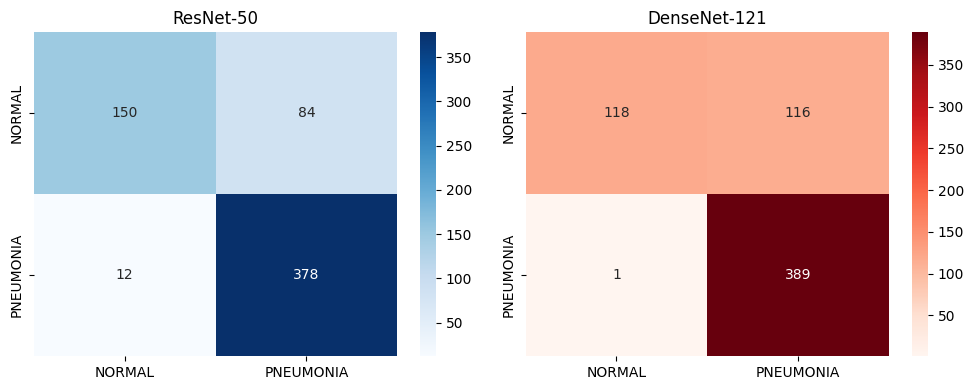

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_resnet = confusion_matrix(resnet_labels, resnet_predictions)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=ax1)
ax1.set_title('ResNet-50')

cm_densenet = confusion_matrix(densenet_labels, densenet_predictions)
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Reds',
            xticklabels=classes, yticklabels=classes, ax=ax2)
ax2.set_title('DenseNet-121')

plt.tight_layout()
plt.show()

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor):
        model_output = self.model(input_tensor)
        class_idx = torch.argmax(model_output, dim=1).item()

        self.model.zero_grad()
        class_score = model_output[0, class_idx]
        class_score.backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = torch.mean(gradients, dim=[1, 2])
        cam = torch.zeros(activations.shape[1:])

        for i in range(len(weights)):
            cam += weights[i] * activations[i, :, :]

        cam = torch.clamp(cam, min=0)
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        return cam.cpu().numpy()

ResNet-50 GradCAM:


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


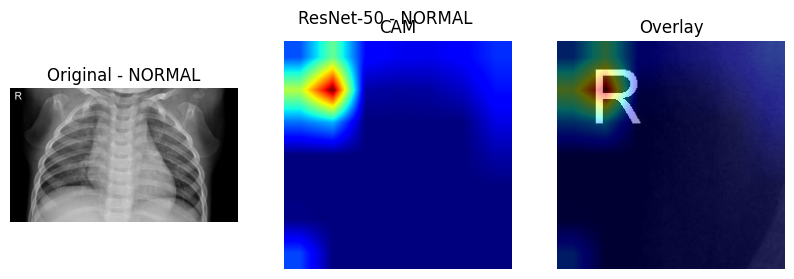

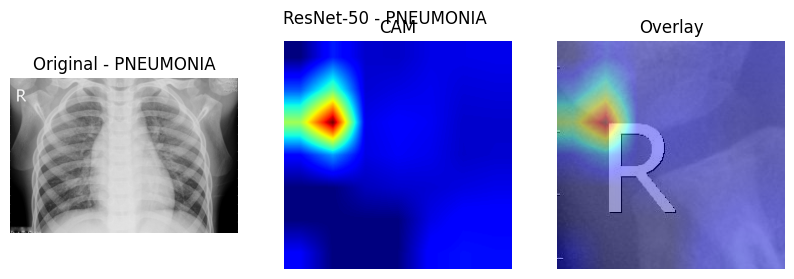

In [ ]:
sample_normal = os.path.join(test_dir, 'NORMAL', os.listdir(os.path.join(test_dir, 'NORMAL'))[0])
sample_pneumonia = os.path.join(test_dir, 'PNEUMONIA', os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[0])

samples = [(sample_normal, 'NORMAL'), (sample_pneumonia, 'PNEUMONIA')]

# ResNet CAM
resnet_gradcam = GradCAM(resnet_model, resnet_model.layer4[-1].conv3)

print("ResNet-50 GradCAM:")
for img_path, true_class in samples:
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    cam = resnet_gradcam.generate_cam(input_tensor)
    cam_resized = cv2.resize(cam, (224, 224))

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    axes[0].imshow(image)
    axes[0].set_title(f'Original - {true_class}')
    axes[0].axis('off')

    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('CAM')
    axes[1].axis('off')

    axes[2].imshow(image)
    axes[2].imshow(cam_resized, cmap='jet', alpha=0.4)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.suptitle(f'ResNet-50 - {true_class}')
    plt.show()

DenseNet-121 GradCAM:


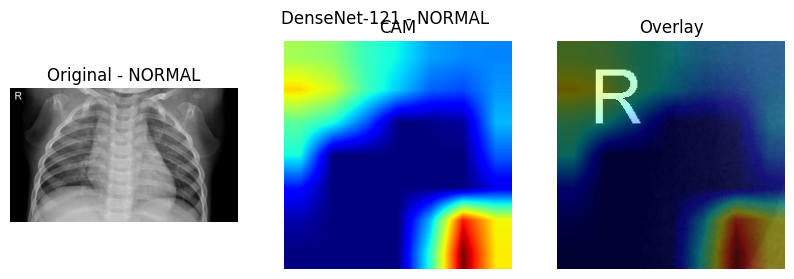

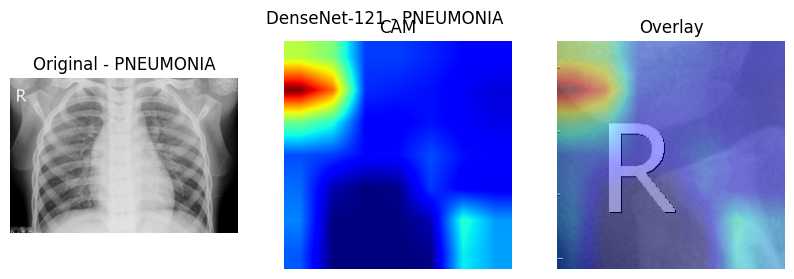

In [ ]:
densenet_gradcam = GradCAM(densenet_model, densenet_model.features.norm5)

print("DenseNet-121 GradCAM:")
for img_path, true_class in samples:
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    cam = densenet_gradcam.generate_cam(input_tensor)
    cam_resized = cv2.resize(cam, (224, 224))

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    axes[0].imshow(image)
    axes[0].set_title(f'Original - {true_class}')
    axes[0].axis('off')

    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('CAM')
    axes[1].axis('off')

    axes[2].imshow(image)
    axes[2].imshow(cam_resized, cmap='jet', alpha=0.4)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.suptitle(f'DenseNet-121 - {true_class}')
    plt.show()

In [ ]:
print("BASELINE EXPERIMENT COMPLETED")
print("="*40)
print("Final Results:")
print(f"ResNet-50    - Accuracy: {resnet_accuracy:.4f}")
print(f"DenseNet-121 - Accuracy: {densenet_accuracy:.4f}")

better_model = "ResNet-50" if resnet_accuracy > densenet_accuracy else "DenseNet-121"
print(f"Winner: {better_model}")
print(f"Accuracy difference: {abs(resnet_accuracy - densenet_accuracy):.4f}")

BASELINE EXPERIMENT COMPLETED
Final Results:
ResNet-50    - Accuracy: 0.8462
DenseNet-121 - Accuracy: 0.8125
Winner: ResNet-50
Accuracy difference: 0.0337


(60.0, 105.0)

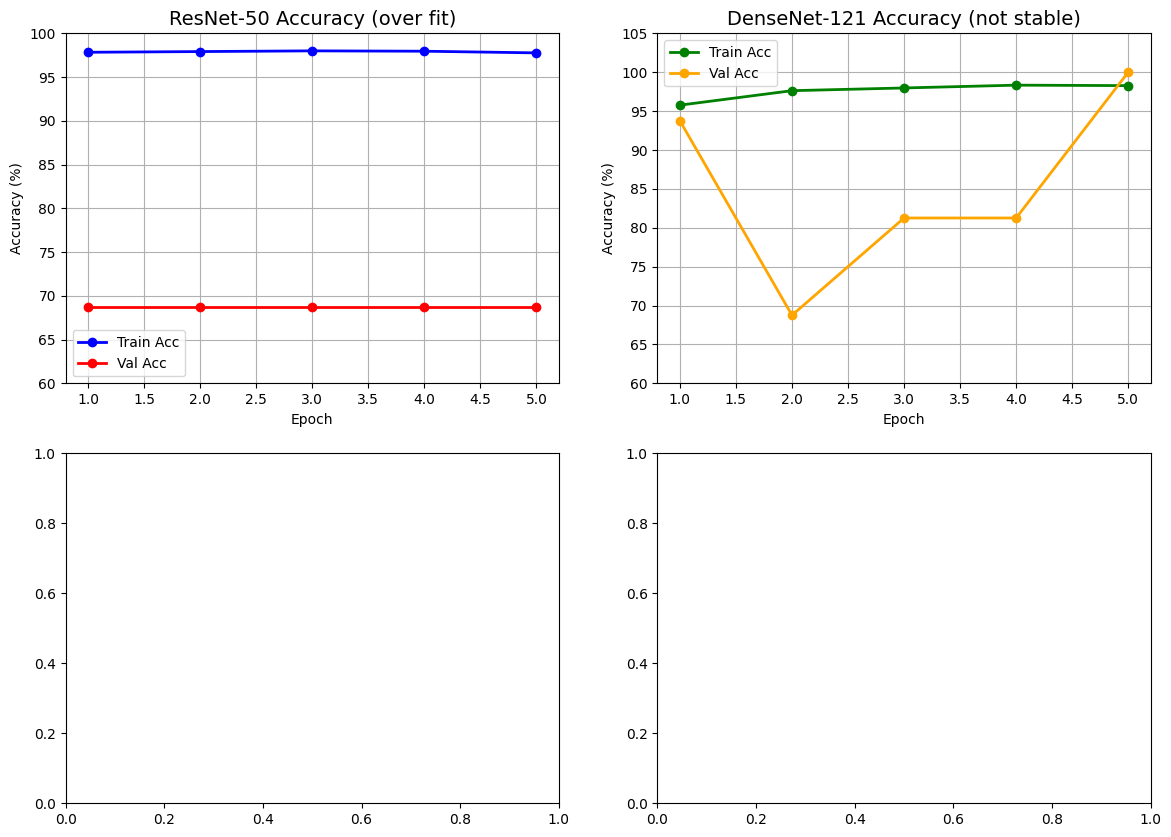

In [ ]:
epochs = list(range(1, 6))
resnet_train_acc = [97.83, 97.91, 97.99, 97.95, 97.76]
resnet_val_acc = [68.75, 68.75, 68.75, 68.75, 68.75]

densenet_train_acc = [95.76, 97.62, 97.97, 98.33, 98.27]
densenet_val_acc = [93.75, 68.75, 81.25, 81.25, 100.00]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ResNet Accuracy
axes[0, 0].plot(epochs, resnet_train_acc, 'b-o', label='Train Acc', linewidth=2)
axes[0, 0].plot(epochs, resnet_val_acc, 'r-o', label='Val Acc', linewidth=2)
axes[0, 0].set_title('ResNet-50 Accuracy (over fit)', fontsize=14)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_ylim([60, 100])

# DenseNet Accuracy
axes[0, 1].plot(epochs, densenet_train_acc, 'g-o', label='Train Acc', linewidth=2)
axes[0, 1].plot(epochs, densenet_val_acc, 'orange', marker='o', label='Val Acc', linewidth=2)
axes[0, 1].set_title('DenseNet-121 Accuracy (not stable)', fontsize=14)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_ylim([60, 105])

renset은 over fit에 densenet은 val이 너무 들쑥날쑥합니다. 보통 데이터 분할을 7:2:1 이나 8:1:1로 하는데 거의 5800장인데 val 데이터가 16장이라 수치가 이상하게 나왔다고 보입니다.  그래도 CNN 모델을 증강 전 후 비교하는거니깐 이대로 진행하겠습니다.